# Training Notebook for VQ-VAE
To be run using on the Google Colab servers

### Global setup

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from time import strftime

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Connect to Github repository and import code

In [3]:
# RUN THIS ONCE AT THE START OF THE SESSION
# clone github repository
!rm -rf /content/VQ-VAE-Tranformer-Image-Gen
!git clone https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen.git

# add repo to sys path to allow imports
import sys
sys.path.append('/content/VQ-VAE-Tranformer-Image-Gen')

Cloning into 'VQ-VAE-Tranformer-Image-Gen'...
remote: Enumerating objects: 443, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 443 (delta 41), reused 68 (delta 22), pack-reused 348 (from 1)
Receiving objects: 100% (443/443), 196.48 MiB | 47.73 MiB/s, done.
Resolving deltas: 100% (219/219), done.


In [4]:
# RUN THIS AT THE START AS WELL AS EVERY TIME THE REPO IS UPDATED
# pull changes from github
%cd /content/VQ-VAE-Tranformer-Image-Gen
!git pull origin
%cd /content

# refrsh the imports
from importlib import reload
import VQ.model_ivo
reload(VQ.model_ivo)

from VQ.model_ivo import Encoder, Decoder, Quantizer, VQ_VAE, LATENT_W, LATENT_H, IMG_H, IMG_W, NUM_EMBEDDINGS

/content/VQ-VAE-Tranformer-Image-Gen
Already up to date.
/content


### Load CelebA dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 97% 1.29G/1.33G [00:00<00:00, 1.13GB/s]
100% 1.33G/1.33G [00:01<00:00, 1.36GB/s]


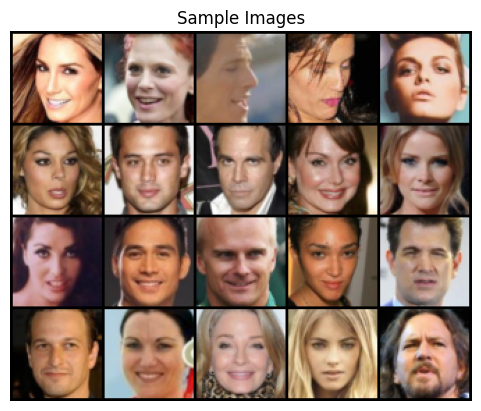

In [5]:
# access the kaggle.json API key from the main folder of your google drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset from kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset
!mkdir ./data
!unzip -q celeba-dataset.zip -d ./data/celeba

from PIL import Image
import pandas as pd

CELEBA_ATTRIBUTES = ['Attractive', 'Smiling', 'Young', 'Male', 'Blond_Hair', 'Black_Hair', 'Brown_Hair', 'Gray_Hair', 'Bald', 'Eyeglasses', 'No_Beard']

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, root: str, attributes: list[str], transform=None):
        """
        Args:
            root (str): path to the root directory of the dataset
            transform: torchvision transforms to apply to each image
        """
        self.attributes = attributes
        self.df = pd.read_csv(os.path.join(root, 'list_attr_celeba.csv'))

        # modify dataframe
        self.df = self.df[['image_id'] + self.attributes]
        self.df = self.df.replace(-1, 0)

        self.image_dir = os.path.join(root, 'img_align_celeba/img_align_celeba')
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # get image filepath and load image
        img_name = row['image_id']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # apply transform
        if self.transform is not None:
            image = self.transform(image)

        # extract targets as LongTensor
        target = torch.tensor(row[self.attributes].to_numpy().astype(np.int64), dtype=torch.long)
        return image, target

class CelebATransform:
    """
    Crops around the face and resizes to IMG_HxIMG_W. Output is a tensor of shape (3, IMG_H, IMG_W) scaled to [0, 1]
    """
    def __call__(self, img):
        img = torchvision.transforms.functional.crop(img, top=60, left=25, height=128, width=128)
        img = torchvision.transforms.functional.resize(img, (IMG_H, IMG_W))
        img = torchvision.transforms.functional.to_tensor(img)
        # img = torchvision.transforms.functional.normalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # uncomment if you want activations in [-1, 1]
        return img

celeba = CelebADataset(root='./data/celeba', attributes=CELEBA_ATTRIBUTES, transform=CelebATransform())

# visualize
grid_x = 5
grid_y = 4

samples = torch.stack([celeba[i][0] for i in range(grid_x*grid_y)])

img = torchvision.utils.make_grid(samples, grid_x, normalize=True, value_range=(0, 1))
plt.title(f'Sample Images')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

### Initialize Model and dataloader

In [6]:
BATCH_SIZE = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = torch.utils.data.DataLoader(celeba, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(use_EMA=True, batch_size=BATCH_SIZE)
vq_vae = VQ_VAE(encoder, decoder, quantizer, use_EMA=True).to(device)

### Training loop

Checkpoint loaded. Resuming from training step 79150.
12:50:08 Begin Training
Training complete.


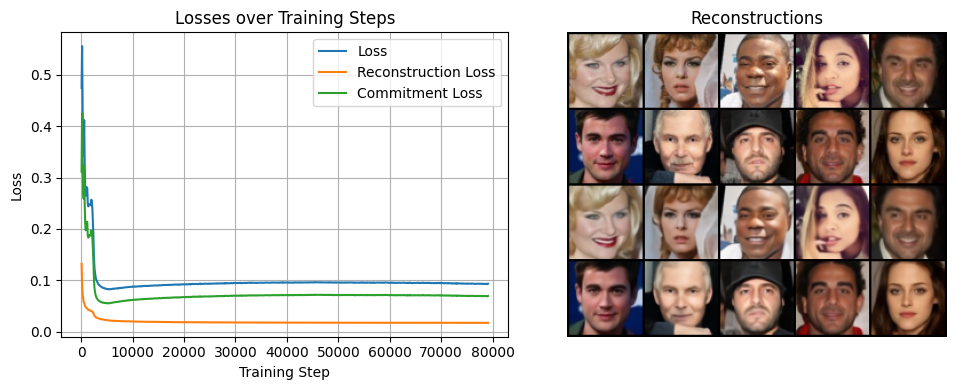

In [7]:
# training hyperparameters
EPOCHS = 0
LEARNING_RATE = 2e-4
LOG_INTERVAL = 100
SAVE_INTERVAL = 1000
SAVE_PATH = '/content/drive/MyDrive/vq_models/vq16_codebook_refresh' # THE SUFFIX '_{training_step}.pt' will be appended

# VQ-VAE training hyperparameters
BETA = 0.25

# optionally, resume training from a checkpoint
CONTINUE_FROM_CHECKPOINT = True #  # str | None
CHECKPOINT_PATH = '/content/drive/MyDrive/vq_models/checkpoint_ivo_new.pt'

# optmizer and training state vars
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=LEARNING_RATE)
train_state = {
    'losses_total': [],
    'losses_recon': [],
    'losses_commit': [],
    'logging_steps': [],
    'running_loss_total': 0.0,
    'running_loss_recon': 0.0,
    'running_loss_commit': 0.0,
    'steps': 0
}

# load from checkpoint
if CONTINUE_FROM_CHECKPOINT:
    train_state = torch.load(CHECKPOINT_PATH, map_location=device)
    vq_vae.load_state_dict(train_state['model_state'])
    optimizer.load_state_dict(train_state['optimizer_state'])
    print(f'Checkpoint loaded. Resuming from training step {train_state['steps']}.')

# training loop
print(f'{strftime('%H:%M:%S')} Begin Training')
end_step = train_state['steps'] + len(dataloader) * EPOCHS
vq_vae.train()
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        # training step
        images, _ = batch
        images = images.to(device)

        reconstruction_loss, commitment_loss = vq_vae(images)
        loss = reconstruction_loss + BETA * commitment_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_state['steps'] += 1
        train_state['running_loss_total'] += loss.item()
        train_state['running_loss_recon'] += reconstruction_loss.item()
        train_state['running_loss_commit'] += commitment_loss.item()

        # logging step
        if train_state['steps'] % LOG_INTERVAL == 0:
            avg_loss_total = train_state['running_loss_total'] / LOG_INTERVAL
            avg_loss_recon = train_state['running_loss_recon'] / LOG_INTERVAL
            avg_loss_commit = train_state['running_loss_commit'] / LOG_INTERVAL
            train_state['running_loss_total'] = 0.0
            train_state['running_loss_recon'] = 0.0
            train_state['running_loss_commit'] = 0.0
            train_state['losses_total'].append(avg_loss_total)
            train_state['losses_recon'].append(avg_loss_recon)
            train_state['losses_commit'].append(avg_loss_commit)
            train_state['logging_steps'].append(train_state['steps'])
            with torch.no_grad():
                p = vq_vae.quantizer.N / vq_vae.quantizer.N.sum() * NUM_EMBEDDINGS
            print(f'{strftime('%H:%M:%S')} TRAINING Step [{train_state['steps']}/{end_step}]; Loss: {avg_loss_total:.6f}; Recon: {avg_loss_recon:.6f}; Commit: {avg_loss_commit:.6f}; Usage (min/med/max/dead): {p.min().item():.4f}, {p.median().item():.2f}, {p.max().item():.2f}, {torch.sum(p < 0.001)}')

        # saving step
        if train_state['steps'] % SAVE_INTERVAL == 0 or (epoch == EPOCHS - 1 and batch_idx == len(dataloader) - 1):
            train_state['model_state'] = vq_vae.state_dict()
            train_state['optimizer_state'] = optimizer.state_dict()
            model_save_path = f'{SAVE_PATH}_{train_state['steps']}.pt'
            torch.save(train_state, model_save_path)
            print(f'{strftime('%H:%M:%S')} Checkpoint saved at step {train_state['steps']} to {model_save_path}')

            # visualize reconstructions
            grid_x = 5
            grid_y = 2
            samples, _ = next(iter(dataloader))
            samples = samples[:grid_x * grid_y // 2].to(device)

            vq_vae.eval()
            reconstructed = vq_vae.reconstruct(samples)
            vq_vae.train()
            images = torch.cat((samples, reconstructed), dim=0)
            img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

            plt.title(f'Reconstructions at step {train_state['steps']}')
            plt.axis('off')
            plt.imshow(img.permute(1,2,0).cpu())
            img_save_path = f'{SAVE_PATH}_{train_state['steps']}_reconstructions.png'
            plt.savefig(img_save_path)
            plt.show()

print(f'Training complete.')

# Prepare reconstructions
grid_x = 5
grid_y = 4
samples, _ = next(iter(dataloader))
samples = samples[:grid_x * grid_y // 2].to(device)

vq_vae.eval()
reconstructed = vq_vae.reconstruct(samples)
images = torch.cat((samples, reconstructed), dim=0)
img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curves
axes[0].plot(train_state['logging_steps'], train_state['losses_total'], label='Loss')
axes[0].plot(train_state['logging_steps'], train_state['losses_recon'], label='Reconstruction Loss')
axes[0].plot(train_state['logging_steps'], train_state['losses_commit'], label='Commitment Loss')

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Losses over Training Steps')
axes[0].legend()
axes[0].grid(True)

# Reconstructions
axes[1].imshow(img.permute(1, 2, 0).cpu())
axes[1].set_title('Reconstructions')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Compute CelebA embeddings

In [8]:
from tqdm import tqdm

SAVE_PATH_INDICES = '/content/drive/MyDrive/vq_models/celeba_indices_uint16_ivo.pt'
SAVE_PATH_ATTRS = '/content/drive/MyDrive/vq_models/celeba_attrs_uint16_ivo.pt'
celeba_indices = []
celeba_attrs = []

vq_vae.eval()
with torch.no_grad():
    for batch in tqdm(dataloader):
        images, attrs = batch
        images = images.to(device)
        indices = vq_vae.compute_indices(images)
        celeba_attrs.append(attrs)
        celeba_indices.append(indices.view(-1, LATENT_W * LATENT_H).cpu())

print('Concatenating...')
celeba_indices = torch.cat(celeba_indices, dim=0)
celeba_attrs = torch.cat(celeba_attrs, dim=0)
print('Shape:', celeba_indices.shape)
print('Shape:', celeba_attrs.shape)
celeba_indices = celeba_indices.to(torch.uint16)
celeba_attrs = celeba_attrs.to(torch.uint16)
print('Saving...')
torch.save(celeba_indices, SAVE_PATH_INDICES)
torch.save(celeba_attrs, SAVE_PATH_ATTRS)

100%|██████████| 792/792 [01:08<00:00, 11.62it/s]


Concatenating...
Shape: torch.Size([202599, 256])
Shape: torch.Size([202599, 11])
Saving...


### Random Image Generation with Uniform Prior

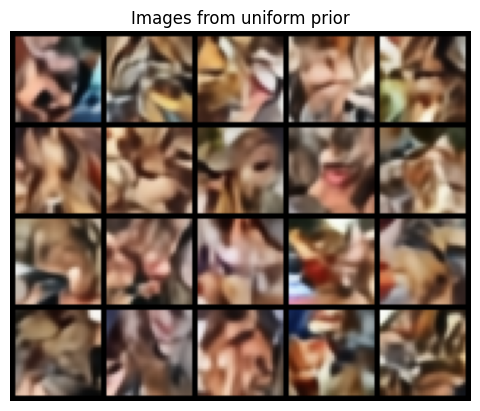

In [9]:
# visualize
grid_x = 5
grid_y = 4

vq_vae.eval()
samples = torch.randint(0, NUM_EMBEDDINGS, (grid_x*grid_y, 8, 8)).to(device)
with torch.no_grad():
    images = vq_vae.reconstruct_from_indices(samples)

img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))
plt.title(f'Images from uniform prior')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())